# **Cassava Leaf Classification using Xception**



> Classifing each cassava image into four disease categories or a fifth category indicating a healthy leaf.

> In doing so the farmers may be able to quickly identify diseased plants, potentially saving their crops.



Source: https://www.kaggle.com/c/cassava-leaf-disease-classification


Install kaggle plugin and use the API to fetch dataset from the competition

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 5.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=a72678624544315399961fcc9ec00f5a772179a4afd82adad5f54f2d51713ee0
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle -v

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Upload kaggle.json

In [35]:
from google.colab import files

files.upload()

{}

Set up directory and give permissions.

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

Download data from kaggle competition. 

In [6]:
! kaggle competitions download -c 'cassava-leaf-disease-classification'

100% 5.75G/5.76G [02:05<00:00, 45.4MB/s]
100% 5.76G/5.76G [02:05<00:00, 49.4MB/s]


In [7]:
import json
import zipfile
import os

Unzip the downloaded data from kaggle.

In [8]:
for file in os.listdir():
    if '.zip' in file:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

Import necessary libiraries required for Xception modelling, augumentation and visualizations.

In [10]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

In [15]:
basepath = "/content"
train_path = os.path.join(basepath,"train_images")
test_path = os.path.join(basepath,'test_images')

In [16]:
train = pd.read_csv(basepath+'/train.csv')
train.head(5)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [17]:
print("Total Number of Images in Training Data : ",train.shape[0])

Total Number of Images in Training Data :  21397


In [18]:
train['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

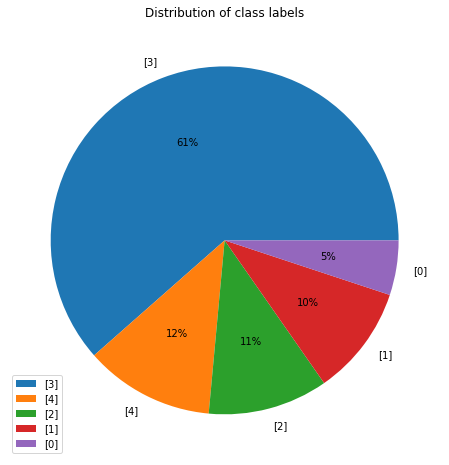

In [19]:
plt.figure(figsize=(20, 8))

plt.pie(
    train.label.value_counts(), 
    labels=['[3]', '[4]', '[2]', '[1]', '[0]'],
    autopct='%d%%'
)
plt.title('Distribution of class labels')
plt.legend()

In [24]:
with open(basepath+"/label_num_to_disease_map.json") as f:
    class_map = json.load(f)
class_map

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

Model Training and Augementation. 

In [49]:
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 350

In [54]:
train.label = train.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     rotation_range = 45,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1,
                                     featurewise_center = True,
                                     featurewise_std_normalization = True)

train_generator = train_datagen.flow_from_dataframe(train,
                         directory = os.path.join(train_path),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse",
                         shuffle= True)


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train,
                         directory = os.path.join(train_path),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [55]:
def create_model():
    conv_base = Xception(include_top=False, weights="imagenet", input_tensor=None,
    pooling=None, input_shape=(TARGET_SIZE, TARGET_SIZE, 3), classifier_activation='softmax')
                               
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [56]:
model = create_model()

In [57]:
model_save = ModelCheckpoint('./Xception_model2.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
2139/2139 [==============================] - 1042s 485ms/step - loss: 0.8677 - acc: 0.6856 - val_loss: 0.7559 - val_acc: 0.7247

Epoch 00001: val_loss improved from inf to 0.75589, saving model to ./Xception_model2.h5
Epoch 2/10
2139/2139 [==============================] - 1037s 484ms/step - loss: 0.6520 - acc: 0.7674 - val_loss: 0.8345 - val_acc: 0.6974

Epoch 00002: val_loss did not improve from 0.75589
Epoch 3/10
2139/2139 [==============================] - 1016s 475ms/step - loss: 0.5867 - acc: 0.7912 - val_loss: 0.9405 - val_acc: 0.7934

Epoch 00003: val_loss did not improve from 0.75589

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
2139/2139 [==============================] - 1025s 479ms/step - loss: 0.4874 - acc: 0.8301 - val_loss: 0.5164 - val_acc: 0.8170

Epoch 00004: val_loss improved from 0.75589 to 0.51640, saving model to ./Xception_model2.h5
Epoch 5/10
2139/2139 [==============================] - 1007s 471ms/step - 

In [58]:
model.save('./Xception_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Load the trained model and use it for predictions

In [41]:
model = models.load_model('Xception_model.h5')

In [42]:
test_image = Image.open(basepath+'/test_images/2216849948.jpg')
# test_image

In [43]:
predict_cassava = []
test_image = test_image.resize((TARGET_SIZE, TARGET_SIZE))
test_image = np.expand_dims(test_image, axis = 0)
predict_cassava.append(np.argmax(model.predict(test_image)))
predict_cassava

[4]

In [ ]:
for img_file in os.listdir('/content/test_images/'):
    if '.jpg' in img_file:
      print('/content/test_images/'+img_file)
      test_image = Image.open('/content/test_images/'+img_file)
      predict_cassava = []
      test_image = test_image.resize((TARGET_SIZE, TARGET_SIZE))
      test_image = np.expand_dims(test_image, axis = 0)
      predict_cassava.append(np.argmax(model.predict(test_image)))
      predict_cassava

/content/test_images/6442965.jpg
/content/test_images/2216849948.jpg
/content/test_images/2321458.jpg
/content/test_images/1726153.jpg
